# 4章　モデルの訓練

## 4.1 線形回帰

* 線形回帰
入力特徴量の加重総和にバイアス項を加えた形  
#### $$\hat{y} = \theta_{0}+\theta_{1}x_{1} + \theta_{2}x_{2}+ \cdots + \theta_{n}x_{n}$$

このモデルの訓練は一般的に２乗平均平方誤差(Root Mean Square Error:RMSE)で評価される
#### $$MSE(\bf{X}, h_{\theta}) = \frac{1}{m}\sum_{i=1}^{m}(\theta^T \cdot x^{(i)} - y^{(i)})^2$$

MSEを最小にするθは代数的な解析(Cf. はじパタ)により、
$\hat{\theta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y$と求められる。
まずはscikit-learnを用いずに行う

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
X = 2*np.random.rand(100,1)
y = 4 + 3*X + np.random.rand(100,1)

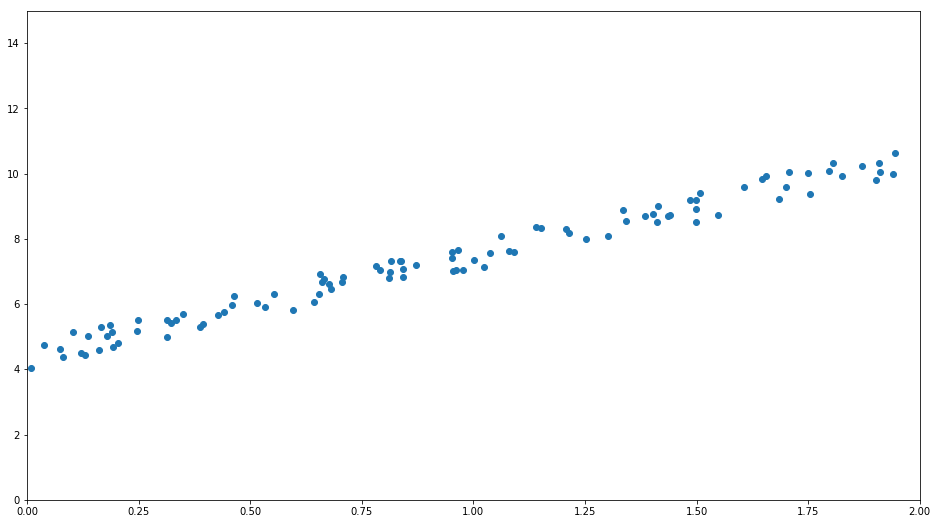

In [19]:
plt.figure(figsize=(16,9))
plt.scatter(X, y)
plt.axis([0,2,0,15])
plt.show()

In [9]:
X_with_bias = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_with_bias.T.dot(X_with_bias)).dot(X_with_bias.T).dot(y)

In [28]:
theta_best

array([[4.43856758],
       [3.07132232]])

In [12]:
X_new = np.array([[0],[2]])
X_new_with_bias = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_with_bias.dot(theta_best)
y_predict

array([[ 4.43856758],
       [10.58121222]])

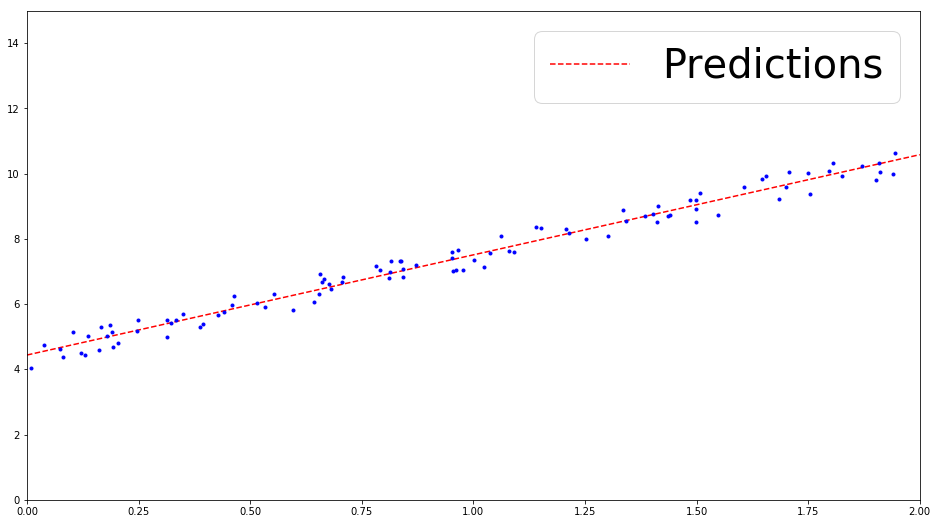

In [18]:
plt.figure(figsize=(16,9))
plt.plot(X_new, y_predict, "r--", label="Predictions")
plt.plot(X,y, "b.")
plt.axis([0,2,0,15])
plt.legend(fontsize=40)
plt.show()

* ```scikit-learn```を用いて実装→結果は同じ

In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([4.43856758]), array([[3.07132232]]))

## 4.2 勾配降下法

毎回コスト関数が小さくなるように、小さなステップでパラメータを動かしていく。
パラメータの動かす度合いを**学習率**という。
全域の最適解が見つからずに局所的最適解に落ち着いてしまうケースあり

* MSEの例  
$$\frac{\partial}{\partial \theta_j}MSE(\theta) = \frac{2}{m}\sum_{i=1}^n(\theta^T \cdot x^{(i)} - y^{(i)})x_j^{(i)}$$

$$\nabla_{\theta}MSE(\theta) = 
\left( \begin{array}{c}
\frac{\partial}{\partial \theta_0}MSE(\theta) \\
\frac{\partial}{\partial \theta_1}MSE(\theta) \\
\vdots\\
\frac{\partial}{\partial \theta_n}MSE(\theta) 
\end{array} \right) = \frac{2}{m} X^T \cdot(X\cdot \theta -y)$$
**この式のXが訓練セット全体のXに対する計算が含まれている→まとめてという意味でバッチと呼ばれている。ゆえに訓練セットが大きくなると計算量が増えるという特徴がある。しかし、特徴量が増えても大丈夫というメリットがある**

学習ステップは
$$\theta^{(n+1)} = \theta^{(n)} -\eta\nabla_\theta MSE(\theta)$$

In [34]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)
for iteration in range(n_iterations):
    gradients_MSE = 2/m * X_with_bias.T.dot((X_with_bias.dot(theta)) - y)
    theta -= eta*gradients_MSE

In [35]:
theta

array([[4.43856758],
       [3.07132232]])

In [146]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_with_bias)
    plt.plot(X,y, 'b.')
    n_iterations=1000
    for iteration in range(n_iterations):
        if iteration <10:
            y_predict = X_new_with_bias.dot(theta)
            style = "r--" if iteration==0 else "b-"
            plt.plot(X_new, y_predict, style)
        gradients_MSE = 2/m * X_with_bias.T.dot((X_with_bias.dot(theta)) - y)
        theta = theta - eta*gradients_MSE
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0,2,0,15])
    plt.title("$\eta = {}$".format(eta), fontsize=16)

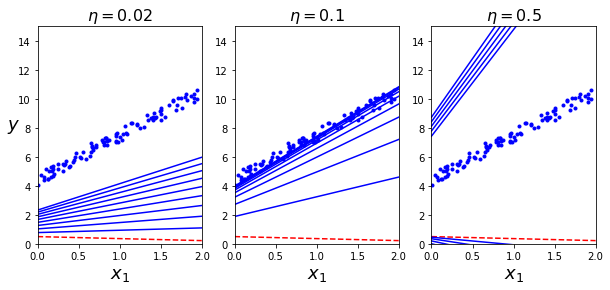

In [147]:
plt.figure(figsize=(10,4))
np.random.seed(42)
theta = np.random.randn(2,1)
plt.subplot(131);plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132);plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133);plot_gradient_descent(theta, eta=0.5)

反復回数は誤差がある$\varepsilon$より小さくなったら中止のような方法を取れば良い

* バッチ勾配降下方の問題点  
→勾配を計算するため、各ステップで全ての訓練セットを全部使うため、計算速度が遅い

確率的勾配降下法(Stochastic Gradient descent:SGD)  
→各ステップで無作為に一つのインスタンスを選び、それだけを使い勾配を計算する。  
最小値に近づいても安定することはない。コスト関数がかなり不規則な時、局所的な最小値の外に飛び出しやすいというメリットがあり、バッチ勾配降下法よりSGDの方が全体の最小値を見つけやすい。
しかし、いつかは落ち着かせる必要はあるのでステップ数に従い学習率を変えることを考える

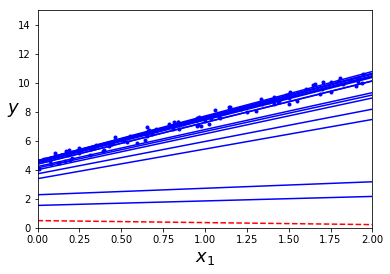

In [93]:
np.random.seed(42)
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1)
theta_path_sgd = []
count = 0
for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_with_bias.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict,style)
            
        random_index = np.random.randint(m)
        Xi = X_with_bias[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients_MSE = 2 *  Xi.T.dot(Xi.dot(theta) - yi)
        eta = learning_schedule(epoch*m + i)
        theta = theta - eta*gradients_MSE
        theta_path_sgd.append(theta)
        
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$",rotation=0, fontsize=18)
plt.axis([0,2,0,15])
plt.show()

In [94]:
theta

array([[4.44327438],
       [3.07802346]])

* sklearnを用いて、SGDを実装

In [100]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.44418114]), array([3.07949385]))

* ミニバッチ勾配降下法  
1つのインスタンスではなく、複数のインスタンスからなるミニバッチを作成し、これを使って勾配を求める。
GPUを使った時に行列演算のハードウェアによる最適化を利用して、パフォーマンスを引き上げられるところが利点らしい？

In [103]:
theta_path_mgd = []

np.random.seed(42)
theta = np.random.randn(2,1)

n_epochs = 50
minibatch_size = 20

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t+t1)

t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_with_bias_shuffled = X_with_bias[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    for i in range(0, m, minibatch_size):
        t += 1
        Xi = X_with_bias_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients_MSE = 2/minibatch_size *  Xi.T.dot(Xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta*gradients_MSE
        theta_path_mgd.append(theta)

In [104]:
theta

array([[4.43541727],
       [3.06414482]])

In [149]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

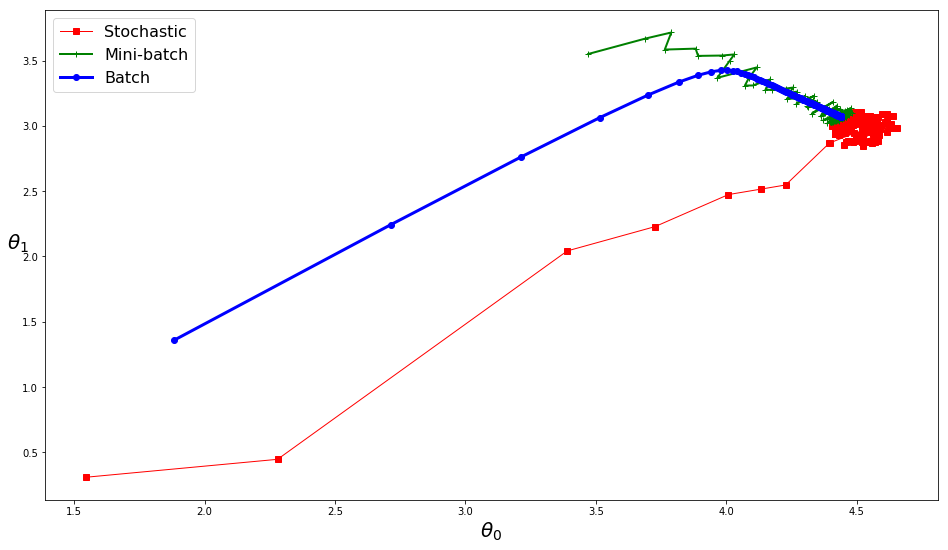

In [154]:
plt.figure(figsize=(16,9))
plt.plot(theta_path_sgd[:,0], theta_path_sgd[:,1], 'r-s', linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:,0], theta_path_mgd[:,1], 'g-+', linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:,0], theta_path_bgd[:,1], 'b-o', linewidth=3, label="Batch")
plt.legend(fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", rotation=0, fontsize=20)
plt.show()

## 4.3多項式回帰

In [220]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X +  2 + np.random.randn(m,1)

In [221]:
from sklearn.preprocessing import PolynomialFeatures

ploy_features = PolynomialFeatures(degree=2, include_bias=False)
X_ploy = ploy_features.fit_transform(X)
print(X[0],X_ploy[0])

[-0.75275929] [-0.75275929  0.56664654]


In [222]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_ploy, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

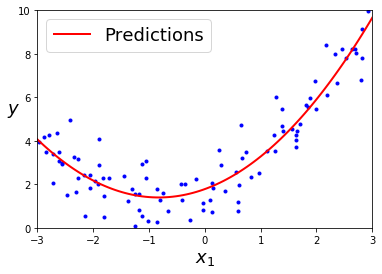

In [223]:
X_new = np.linspace(-3,3,100).reshape(100,1) #-3->3まで100等分割し、100,1にreshape
X_new_ploy = ploy_features.transform(X_new)
y_new = lin_reg.predict(X_new_ploy)
# plt.figure(figsize=(16,9))
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-', linewidth=2, label='Predictions')

plt.legend(fontsize=18,loc='upper left')
plt.xlabel("$x_1$",fontsize=18)
plt.ylabel("$y$",fontsize=18, rotation=0)
plt.axis([-3,3,0,10])
plt.show()

元の関数は、$y=\frac{1}{2}x_1^2 + x_1 + 2 + Gaussian\_Noise$  
予測されたものは $y = 0.56 x_1^2 + 0.934x_1 + 1.78$

## 4.4学習曲線
次は1次2次、300次元の回帰モデルを実装する

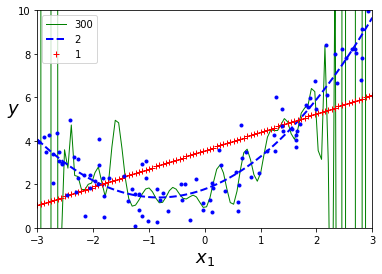

In [224]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in [("g-", 1, 300), ("b--",2, 2), ("r+",2,1)]:
    ploybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    ploynomial_regression = Pipeline([
        ("ploy_features", ploybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg)
    ])
    ploynomial_regression.fit(X,y)
    y_newbig = ploynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label = str(degree), linewidth=width)

plt.plot(X,y,'b.')
plt.legend(loc='upper left')
plt.xlabel("$x_1$",fontsize=18)
plt.ylabel("$y$",fontsize=18, rotation=0)
plt.axis([-3,3,0,10])
plt.show()
plt.show()

In [225]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [226]:
def plot_learning_curves(model,X,y):
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors = []
    val_errors = []
    for m in range(1, len(X)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Train Set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation Set")
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("$RMSE$", fontsize=14)
    plt.legend()

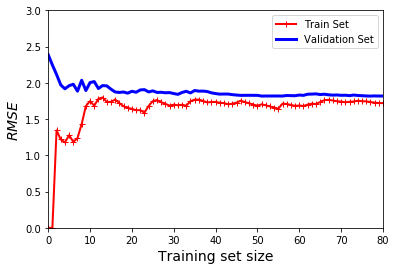

In [227]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0,80,0,3.0])
plt.show()

これは過少適合→両者のRMSEが近づいているが全体として誤差が大きい  
もっと複雑なモデル(例えばもっと次元数をあげる等)を使う必要がある

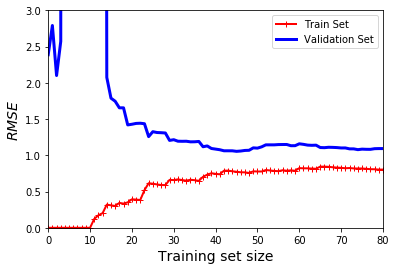

In [228]:
dim10_polynomial_regression = Pipeline([
    ("polynomial_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])
plot_learning_curves(dim10_polynomial_regression, X,y)
plt.axis([0,80,0,3.0])
plt.show()

* Trainの場合とvalidationの場合で差が大きい→過学習気味
* 線形回帰より高性能

# 4.5 正則化された線形回帰
モデルの制約の強化は、モデルの過学習を緩和するために良い方法  
例えば多項式回帰モデルは次元を下げること等
線形回帰の正則化は一般にモデルの重みを制限する。リッジ回帰、Lasso回帰、ElasticNetの3方法

* リッジ回帰
コスト関数に$\alpha\sum_{i=1}^{n}\theta_i^2$という正則化項を加える
$$
J(\theta) = MSE(\theta)+\alpha\frac{1}{2}\sum_{i=1}^n\theta_i^2
$$

In [240]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

np.random.seed(42)
m = 20
X = 3* np.random.rand(m,1)
y = 1 + 0.5 * X + np.random.randn(m,1)/1.5
X_new = np.linspace(0,3 ,100).reshape(100,1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs) if alpha>0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ("polybig_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scalor", StandardScaler()),
                ("regul_reg", model)
            ])
        model.fit(X,y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha >0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X,y, "b.", linewidth=3)
    plt.legend(fontsize=15)
    plt.xlabel("$x_1$",fontsize=18)
    plt.axis([0,3,0,4])

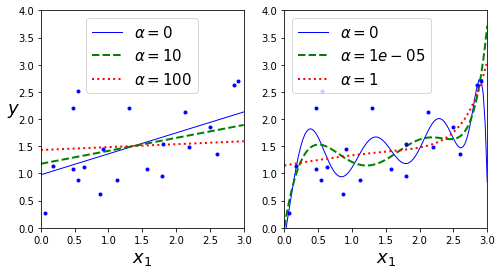

In [241]:
plt.figure(figsize=(8,4))
plt.subplot(121);plot_model(Ridge, polynomial=False, alphas=[0,10,100], random_state=42)
plt.ylabel("$y$",rotation=0, fontsize=18)
plt.subplot(122);plot_model(Ridge, polynomial=True, alphas=[0,10**-5,1], random_state=42)
plt.show()

In [244]:
ridge_reg = Ridge(solver='cholesky', random_state=42)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [251]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=5, penalty='l2', random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.13500145])

* Lasso回帰  
リッジ回帰ではl2ノルムを用いたが、Lasso回帰ではL1ノルムを持ちいる。すなわち
$$
J(\theta) = MES(\theta) + \alpha \sum_{i=1}^{n}|\theta_i|
$$
疎なモデル(Sparse Model)を出力する

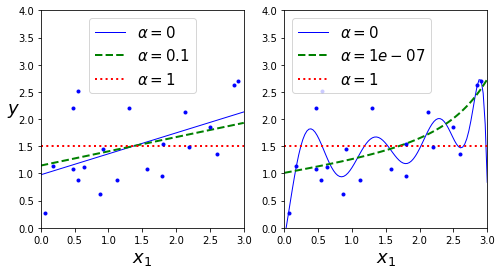

In [252]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121);plot_model(Lasso, polynomial=False, alphas=[0, 0.1 ,1], random_state=42)
plt.ylabel("$y$",rotation=0, fontsize=18)
plt.subplot(122);plot_model(Lasso, polynomial=True, alphas = [0,10**-7,1], tol=1, random_state=42)

plt.show()

 * Elastic Net  
 リッジ回帰とLasso回帰の中間
 $$
 J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^{n}|\theta_i| + \frac{1-r}{2}\alpha \sum_{i=1}^{2}\theta_i^2
 $$
 
* リッジとLassoとElastic Netの使い分け  
    * ほとんど全ての場合、何らかの正則化をするべき
    * リッジは良いデフォルト
    * 一部の特徴量だけのみ重要？→Lasso
    * Lassoは特徴量が多すぎる時や、特徴量同士が何らかの関係があると不規則な動き→ElasticNetの方がよい

In [253]:
from sklearn.linear_model import ElasticNet

In [254]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([1.54333232])

* 早期打ち切り  
エポックが増える→過学習になる(Trainに対しては性能UP,Validationに対しては性能Down)  
検証誤差が最小になった時に学習をやめる

In [297]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m,1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [298]:
poly_scaler = Pipeline([
    ("polybig_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler()),
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

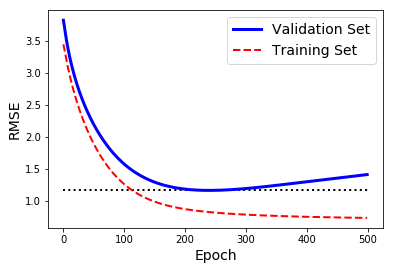

In [299]:
sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005, random_state=42)

n_epochs = 500
train_errors = []
val_errors = []

for i in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_pred = sgd_reg.predict(X_train_poly_scaled)
    y_val_pred = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    val_errors.append(mean_squared_error(y_val, y_val_pred))
    
best_epoch = np.argmin(val_errors)
best_val_RMSE = np.sqrt(val_errors[best_epoch])

plt.plot([0,n_epochs], [best_val_RMSE, best_val_RMSE], 'k:', linewidth=2)
plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label="Validation Set")
plt.plot(np.sqrt(train_errors), 'r--', linewidth=2, label="Training Set")
plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [300]:
from sklearn.base import clone
sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005,random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [302]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=None,
        n_iter=1, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
        verbose=0, warm_start=True))

# 4.6 ロジスティック回帰

線形回帰モデルと同様に加重総和(にバイアス項を加えたもの)を返すが、ロジスティック回帰は結果のロジスティックを返す

$$
\hat{p} = h_{\theta}({\bf x}) = \sigma(\theta^T \cdot x)
$$
$\sigma(t)$はシグモイド関数($\frac{1}{1+\exp{(-t)}}$)。得られた値が0.5より大きいか否かで判別。コスト関数は
$$
J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}\log{\hat{p}^{(i)}}+(1-y^{(i)})\log({1-\hat{p}^{(i)}})
$$
これを最小にするθは解析的には求められないが、勾配降下法なら求められるので、$\theta_j$で偏微分すると

$$
\frac{\partial}{\partial \theta_j} J(\theta) = \frac{1}{m}\sum_{i=1}^{m}((\sigma(\theta^T \cdot {\bf x}^{(i)}) - y^{(i)}) x_j^{(i)}
$$
全ての勾配を集めた勾配ベクトルを作れば、ミニバッチでの学習も可能。詳しい式展開は「初めてのパターン認識」へ  
* Irisデータでの実装 ただし花弁の幅データ(petal width)だけでバージニカを分析

In [1]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [2]:
iris['feature_names'], iris['target_names']

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [6]:
X = iris['data'][:, 3:] #shapeを(150,1)にする。最後の':'がないと、(150,)となる
y = (iris['target']==2).astype(np.int)

In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Text(0.5, 0, 'Petal width(cm)')

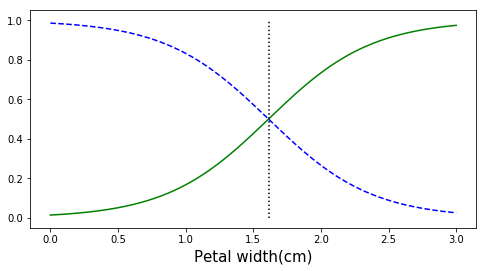

In [10]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.figure(figsize=(8,4))
plt.plot(X_new, y_proba[:,1],'g-', label='Iris-Virginica')
plt.plot(X_new, y_proba[:,0],'b--', label='Not Iris-Virginica')

decition_boundary = X_new[y_proba[:,1]>=0.5][0]
plt.plot([decition_boundary, decition_boundary], [0,1], 'k:')
plt.xlabel("Petal width(cm)", fontsize=15)

In [11]:
decition_boundary = X_new[y_proba[:,1]>=0.5][0]
decition_boundary

array([1.61561562])

In [15]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

ロジスティック回帰の多変数

In [73]:
X = iris['data'][:,2:4]
y = (iris['target'] == 2).astype(np.int)

log_reg = LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X,y)

LogisticRegression(C=10000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [74]:
log_reg.intercept_, log_reg.coef_

(array([-45.26057652]), array([[ 5.75286199, 10.44454566]]))

In [75]:
# 境界線の作成に利用
left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]
left_right, boundary

(array([2.9, 7. ]), array([2.73609573, 0.47781328]))

In [76]:
#基準用の格子点の作成。これにより、(0,0) -> (x0[0][0], x1[0][0])のように定義可能
x0,x1 = np.meshgrid(
    np.linspace(2.9,7,500).reshape(-1,1),
    np.linspace(0.8, 2.7, 200).reshape(-1,1)
)
print("(0,0) = ({},{})".format(x0[0][0], x1[0][0]))

(0,0) = (2.9,0.8)


In [77]:
X_new = np.c_[x0.ravel(), x1.ravel()] # 格子点を入力データのように整形（10000,2 )
y_proba = log_reg.predict_proba(X_new)
y_proba #等高線の作成に利用

array([[9.99999998e-01, 1.65140362e-09],
       [9.99999998e-01, 1.73133642e-09],
       [9.99999998e-01, 1.81513821e-09],
       ...,
       [9.14530673e-11, 1.00000000e+00],
       [8.72308892e-11, 1.00000000e+00],
       [8.32036662e-11, 1.00000000e+00]])

[2.9, 7, 0.8, 2.7]

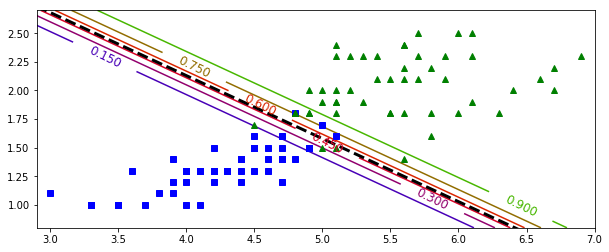

In [78]:
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg) #zzは高さ(今回で言えば、確率)

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--",linewidth=3)
plt.axis([2.9, 7, 0.8, 2.7])

* softmax回帰   
2項分類器を組み合わせてマルチ分類器を作成可能。ロジスティック回帰を用いたものをソフトマックス回帰という。クラスkについて。
$$
s_k({\bf x}) = (\theta^{(k)})^T\cdot {\bf x}\\\\
\hat{p}_k = \sigma({\bf s(x))}_k = \frac{\exp{(s_k(x))}}{\sum_{j=i}^{K} \exp{(s_j(x))}}
$$
クロスエントロピー関数

$$
J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^K y_k^{(i)} \log{\bigl( \hat{p}_k^{(i)} \bigr)}
$$

$$
\nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} \bigl( \hat{p}_k^{(i)} - y_k^{(i)} \bigr) {\bf x}
$$

In [83]:
X = iris['data'][:,2:4]
y = iris['target']

#multi_class = 'multinomial'にするとsoftmaxで計算してくれる。softmaxを利用する場合、solverとしてlbfgsを利用
softmax_reg = LogisticRegression(multi_class="multinomial", solver='lbfgs', C=10, random_state=42)
softmax_reg.fit(X,y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [84]:
softmax_reg.predict([[5, 2]])

array([2])

In [85]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

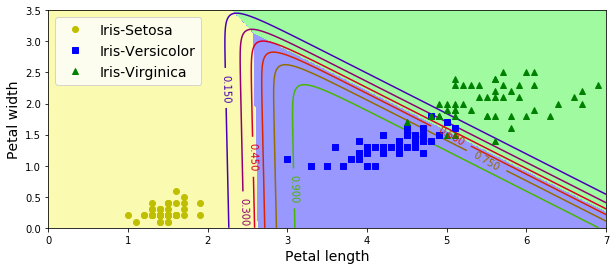

In [99]:
x0,x1 = np.meshgrid(
    np.linspace(0, 8.0, 500).reshape(-1,1),
    np.linspace(0,3.5, 200).reshape(-1,1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:,1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
#各irisのデータの散布図をプロット
plt.plot(X[y==0, 0], X[y==0, 1], 'yo', label="Iris-Setosa")       #setosa
plt.plot(X[y==1, 0], X[y==1, 1], 'bs', label = "Iris-Versicolor") #versicolor
plt.plot(X[y==2, 0], X[y==2, 1], 'g^', label = 'Iris-Virginica')  #virginica

#境界線を色付け
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
plt.contourf(x0,x1,zz, cmap=custom_cmap)

#等高線の記述
contour = plt.contour(x0,x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour)    #ラベルの数値の記述

#軸の名前など細かい調整
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc = "optimize", fontsize=14)
plt.axis([0,7,0,3.5])
plt.show()

## 4.7 演習問題
1. 数百万もの特徴量を持つ訓練セットがあるときの線形回帰訓練アルゴリズム  
→確率的勾配降下法(収まるならミニバッチ)  
2. 訓練セットの特徴量のスケールがまちまち。これによって悪影響を受けるアルゴリズムは何で、どのような影響があるか。またその問題にはどのように対処すれば良いか。  
→確率的勾配降下法(ミニバッチ)に対して、選ばれたインスタンスに依存するため、検証誤差が大きくなるであろうと思われる。スケーリング等で対処可能
3. ロジスティック回帰モデルを訓練している時に、勾配降下法が局所的な最小値から抜け出せなくなることはあるか    
→ない
4. 十分な実行時間を与えれば、全ての勾配効果法アルゴリズムは同じモデルに帰着するか  
→しない。最初が違って他の解に行ったら帰着しない。`確率で選ぶインスタンスが違うので、同じモデルとはいかない`
5. バッチ勾配降下法を使っていて、エポックごとに検証誤差をプロットしている。検証誤差が絶えず大きくなっていることに気づいた場合、何が起きているか。また問題はどのように修正すればいいか。  
→過学習。ちょうど良いエポックを見つけることで対処。+`訓練誤差も上がっているなら、学習率にも問題あり`
6. 検証誤差が上がりだした時にミニバッチ勾配降下法をすぐに中止するのは良いことか？   
→~~よいこと？時間の短縮.~~ `訓練するたびに良くなるという保証はない。ゆえにちょっと泳がせるのが良い`
7. 本書で取り上げた勾配降下法アルゴリズムの中で、最適な解の近辺に最も早く到達するのはどれか。それは実際に収束するか。他の勾配降下法も収束させるにはどうすればよいか。
→~~ミニバッチ。収束はしない。実行回数をあげる~~確率的勾配降下法。訓練イテレーションが早く終わることが主な理由　
8. 多項式回帰を使っている。学習曲線をプロットしたところ、訓練誤差と検証誤差の差が大きい。何が起きているか。解決方法を3つあげよ。  
過学習している？　多項式回帰の字数を下げる。モデルの自由度を減らす。学習セットを増やす